In [2]:
import tensorflow.keras as keras
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Dropout, Embedding, LSTM
from tensorflow.keras.optimizers import RMSprop, Adam, Nadam
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import TensorBoard

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.preprocessing import MinMaxScaler

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

import tensorflow 
import sys
print("Python: ", sys.version)

print("pandas: ", pd.__version__)
print("numpy: ", np.__version__)
print("seaborn: ", sns.__version__)
print("matplotlib: ", matplotlib.__version__)
print("sklearn: ", sklearn.__version__)
print("Tensorflow: ", tensorflow.__version__)

Python:  3.12.6 (main, Sep  8 2024, 13:18:56) [GCC 14.2.1 20240805]
pandas:  2.2.3
numpy:  1.26.3
seaborn:  0.13.2
matplotlib:  3.8.2
sklearn:  1.5.2
Tensorflow:  2.18.0


In [3]:


class Visualization:
    labels = ["Normal", "Anomaly"]

    def draw_anomaly(self, y, error, threshold):
        groupsDF = pd.DataFrame({'error': error,
                                 'true': y}).groupby('true')

        figure, axes = plt.subplots(figsize=(12, 8))

        for name, group in groupsDF:
            axes.plot(group.index, group.error, marker='x' if name == 1 else 'o', linestyle='',
                    color='r' if name == 1 else 'g', label="Anomaly" if name == 1 else "Normal")

        axes.hlines(threshold, axes.get_xlim()[0], axes.get_xlim()[1], colors="b", zorder=100, label='Threshold')
        axes.legend()
        
        plt.title("Anomalies")
        plt.ylabel("Error")
        plt.xlabel("Data")
        plt.show()

    def draw_error(self, error, threshold):
        plt.figure(figsize=(10, 8))
        plt.plot(error, marker='o', ms=3.5, linestyle='',
                 label='Point')

        plt.hlines(threshold, xmin=0, xmax=len(error)-1, colors="r", zorder=100, label='Threshold')
        plt.legend()
        plt.title("Reconstruction error")
        plt.ylabel("Error")
        plt.xlabel("Data")
        plt.show()



In [4]:
tensorlogs = ["art_daily_no_noise", #0
              "art_daily_nojump", #1
              "art_daily_jumpsdown",#2 
              "art_daily_perfect_square_wave", #3 
              "art_increase_spike_density",  #4
              "art_load_balancer_spikes",  #5
              "ambient_temperature_system_failure", #6 
              "nyc_taxi",  #7
              "ec2_cpu_utilization", #8
              "rds_cpu_utilization"] #9 

dataFilePaths = ['data/art_daily_no_noise.csv',
                 'data/art_daily_nojump.csv',
                 'data/art_daily_jumpsdown.csv',
                 'data/art_daily_perfect_square_wave.csv',
                 'data/art_increase_spike_density.csv',
                 'data/art_load_balancer_spikes.csv',
                 'data/ambient_temperature_system_failure.csv',
                 'data/nyc_taxi.csv',
                 'data/ec2_cpu_utilization.csv',
                 'data/rds_cpu_utilization.csv']

In [15]:


i = 7

tensorlog = tensorlogs[i]
dataFilePath = dataFilePaths[i]
print("tensorlog: ", tensorlog)
print("dataFilePath: ", dataFilePath)



tensorlog:  nyc_taxi
dataFilePath:  data/nyc_taxi.csv


In [16]:


df = pd.read_csv(filepath_or_buffer=dataFilePath, header=0, sep=',')
print('Shape:' , df.shape[0])
print('Head:')
print(df.head(5))



Shape: 10320
Head:
             timestamp  value
0  2014-07-01 00:00:00  10844
1  2014-07-01 00:30:00   8127
2  2014-07-01 01:00:00   6210
3  2014-07-01 01:30:00   4656
4  2014-07-01 02:00:00   3820


             timestamp  value            Datetime
0  2014-07-01 00:00:00  10844 2014-07-01 00:00:00
1  2014-07-01 00:30:00   8127 2014-07-01 00:30:00
2  2014-07-01 01:00:00   6210 2014-07-01 01:00:00


Text(0.5, 1.0, 'Time Series of value by date time')

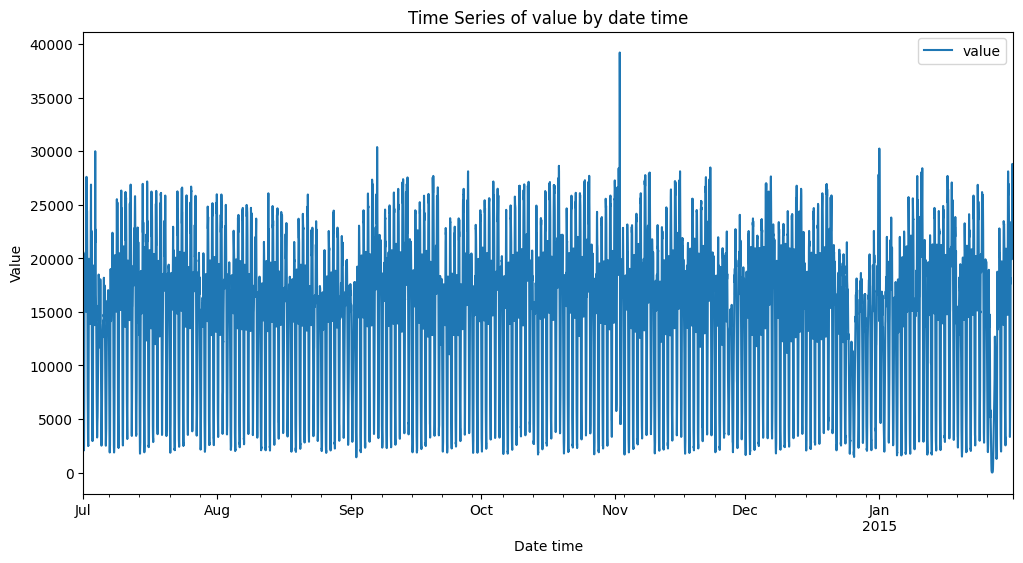

In [17]:
df['Datetime'] = pd.to_datetime(df['timestamp'])
print(df.head(3))
df.shape
df.plot(x='Datetime', y='value', figsize=(12,6))
plt.xlabel('Date time')
plt.ylabel('Value')
plt.title('Time Series of value by date time')

In [18]:
df.value.describe()

count    10320.000000
mean     15137.569380
std       6939.495808
min          8.000000
25%      10262.000000
50%      16778.000000
75%      19838.750000
max      39197.000000
Name: value, dtype: float64

<Axes: title={'center': 'Before Scaling'}, xlabel='value', ylabel='Density'>

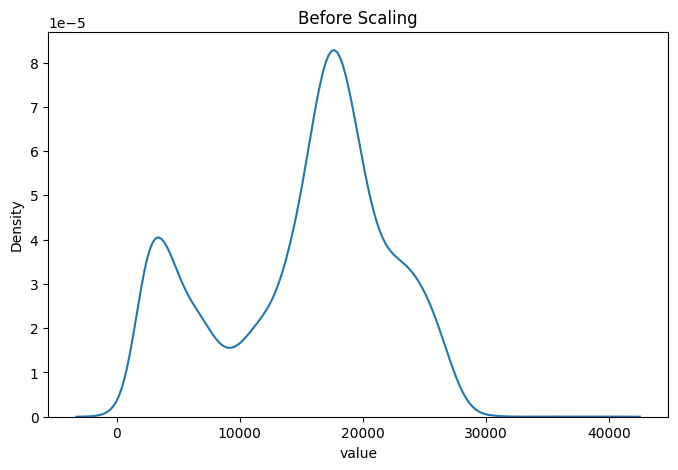

In [19]:


fig, (ax1) = plt.subplots(ncols=1, figsize=(8, 5))
ax1.set_title('Before Scaling')
sns.kdeplot(df['value'], ax=ax1)



In [20]:


from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0, 1))
df['scaled_value'] = pd.DataFrame(scaler.fit_transform(pd.DataFrame(df['value'])),columns=['value'])
print('Shape:' , df.shape[0])
df.head(5)



Shape: 10320


,timestamp,value,Datetime,scaled_value
0,2014-07-01 00:00:00,10844,2014-07-01 00:00:00,0.276506
1,2014-07-01 00:30:00,8127,2014-07-01 00:30:00,0.207175
2,2014-07-01 01:00:00,6210,2014-07-01 01:00:00,0.158259
3,2014-07-01 01:30:00,4656,2014-07-01 01:30:00,0.118605
4,2014-07-01 02:00:00,3820,2014-07-01 02:00:00,0.097272


<Axes: title={'center': 'After Scaling'}, xlabel='scaled_value', ylabel='Density'>

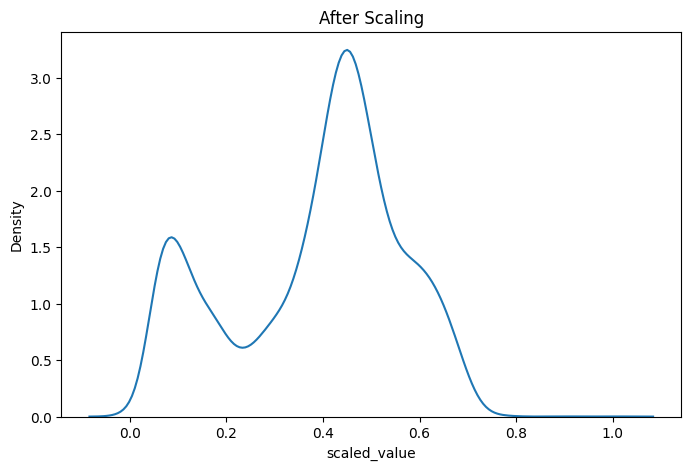

In [21]:


fig, (ax1) = plt.subplots(ncols=1, figsize=(8, 5))
ax1.set_title('After Scaling')
sns.kdeplot(df['scaled_value'], ax=ax1)



In [22]:
df.head(5)

,timestamp,value,Datetime,scaled_value
0,2014-07-01 00:00:00,10844,2014-07-01 00:00:00,0.276506
1,2014-07-01 00:30:00,8127,2014-07-01 00:30:00,0.207175
2,2014-07-01 01:00:00,6210,2014-07-01 01:00:00,0.158259
3,2014-07-01 01:30:00,4656,2014-07-01 01:30:00,0.118605
4,2014-07-01 02:00:00,3820,2014-07-01 02:00:00,0.097272


In [23]:


time_steps = 16
metric = 'mean_absolute_error'

model = Sequential()
model.add(LSTM(units=64, activation='tanh', input_shape=(time_steps-1, 1), return_sequences=True))
model.add(LSTM(units=1, activation='sigmoid'))

model.compile(optimizer='adam', loss='mean_absolute_error', metrics=[metric])
print(model.summary())



/home/jmorris/.cache/pypoetry/virtualenvs/data-science-consultant-lessons-6aIS_sqJ-py3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 15, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 1)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,160 (67.03 KB)

 Trainable params: 17,160 (67.03 KB)

 Non-trainable params: 0 (0.00 B)

None


In [24]:
sequence = np.array(df['scaled_value'])
print(sequence)

# Create rolling window sequences as determined by time_steps
x_sequences = []
y_sequences = []

# Number of windows to iterate through
n_iter = len(sequence) - time_steps + 1
for f in range(n_iter):
    window = sequence[f:f+time_steps]
    x_sequences.append(window[:-1])
    y_sequences.append(window[-1:])
x_sequences = np.array(x_sequences)
y_sequences = np.array(y_sequences)
print(x_sequences.shape, y_sequences.shape)


[0.27650616 0.20717548 0.1582587  ... 0.69664957 0.6783281  0.67059634]
(10305, 15) (10305, 1)


In [29]:
len(sequence)

10320

In [283]:
sequences_x = x_sequences.reshape(len(x_sequences), time_steps-1, 1)
print("sequences_x: ", sequences_x.shape)
sequences_y = y_sequences.reshape(len(y_sequences), 1)
print("sequences_y: ", sequences_y.shape)

# Training on first half of data only, predicting on whole thing
stop_point = int(0.5 * len(df))
training_x = sequences_x[:stop_point]
print("training_x: ", training_x.shape)
training_y = sequences_y[:stop_point]
print("training_y: ", training_y.shape)

batch_size=32
epochs=5

model.fit(x=training_x, y=training_y,
                       batch_size=batch_size, epochs=epochs,
                       verbose=1, validation_data=(training_x, training_y),
                       callbacks=[TensorBoard(log_dir='./logs/{0}'.format(tensorlog))])

sequences_x:  (10305, 15, 1)
sequences_y:  (10305, 1)
training_x:  (5160, 15, 1)
training_y:  (5160, 1)
Epoch 1/5
162/162 [==============================] - 10s 50ms/step - loss: 0.1008 - mean_absolute_error: 0.1008 - val_loss: 0.0682 - val_mean_absolute_error: 0.0682
Epoch 2/5
162/162 [==============================] - 7s 45ms/step - loss: 0.0564 - mean_absolute_error: 0.0564 - val_loss: 0.0525 - val_mean_absolute_error: 0.0525
Epoch 3/5
162/162 [==============================] - 7s 45ms/step - loss: 0.0481 - mean_absolute_error: 0.0481 - val_loss: 0.0422 - val_mean_absolute_error: 0.0422
Epoch 4/5
162/162 [==============================] - 8s 46ms/step - loss: 0.0411 - mean_absolute_error: 0.0411 - val_loss: 0.0395 - val_mean_absolute_error: 0.0395
Epoch 5/5
162/162 [==============================] - 7s 46ms/step - loss: 0.0368 - mean_absolute_error: 0.0368 - val_loss: 0.0346 - val_mean_absolute_error: 0.0346


In [284]:
import math
from sklearn.metrics import mean_squared_error

testing_dataset = sequences_x
print("testing_dataset: ", testing_dataset.shape)

print("sequences_y: ", sequences_y.shape)

testing_pred = model.predict(x=testing_dataset)
print("testing_pred: ", testing_pred.shape)

errorsDF = sequences_y - testing_pred
print(errorsDF.shape)
rmse = math.sqrt(mean_squared_error(sequences_y, testing_pred))
print('Test RMSE: %.3f' % rmse)

testing_dataset:  (10305, 15, 1)
sequences_y:  (10305, 1)
testing_pred:  (10305, 1)
(10305, 1)
Test RMSE: 0.053


In [285]:
#based on cutoff after sorting errors
# Calculate threshold using training error
dist = np.linalg.norm(sequences_y[:len(training_y)] - testing_pred[:len(training_y)], axis=-1)

scores =dist.copy()
print(scores.shape)
scores.sort()
cutoff = int(0.999 * len(scores))
print(cutoff)
threshold= scores[cutoff]

# Calculate total error over full sequence
dist = np.linalg.norm(sequences_y[:] - testing_pred, axis=-1)

print(threshold)

(5160,)
5154
0.20640651387498998


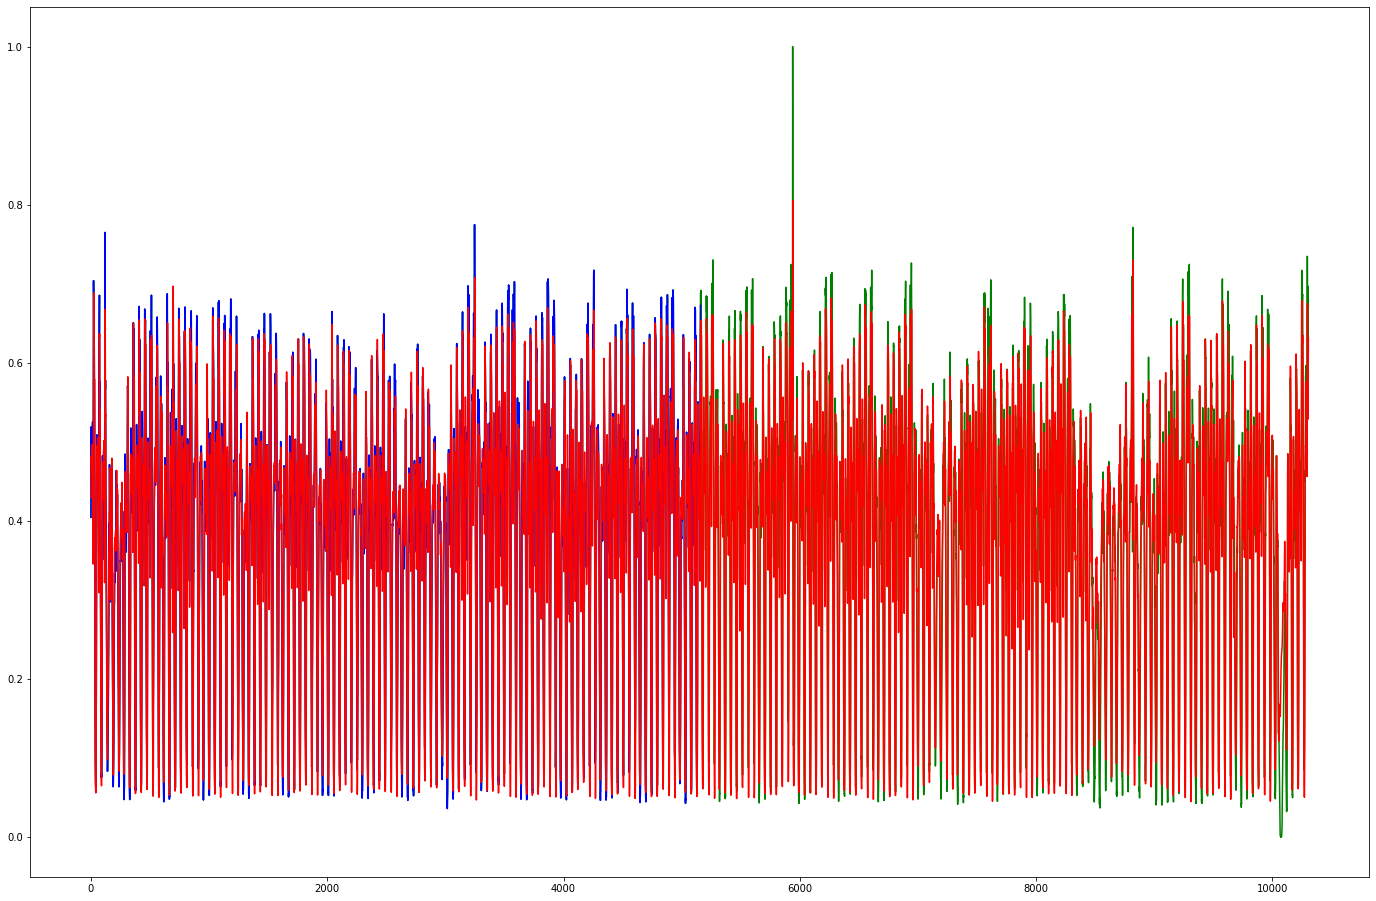

In [286]:
plt.figure(figsize=(24,16))
plt.plot(sequences_y, color='green')
plt.plot(training_y, color='blue')
plt.plot(testing_pred, color='red')

In [287]:


#label the records anomalies or not based on threshold
z = zip(dist >= threshold, dist)

y_label=[]
error = []
for idx, (is_anomaly, dist) in enumerate(z):
    if is_anomaly:
        y_label.append(1)
    else:
        y_label.append(0)
    error.append(dist)
    



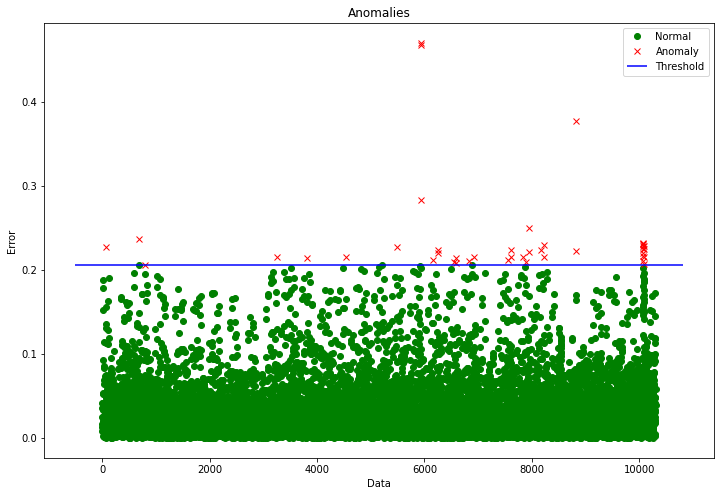

In [288]:
viz = Visualization()
viz.draw_anomaly(y_label, error, threshold)

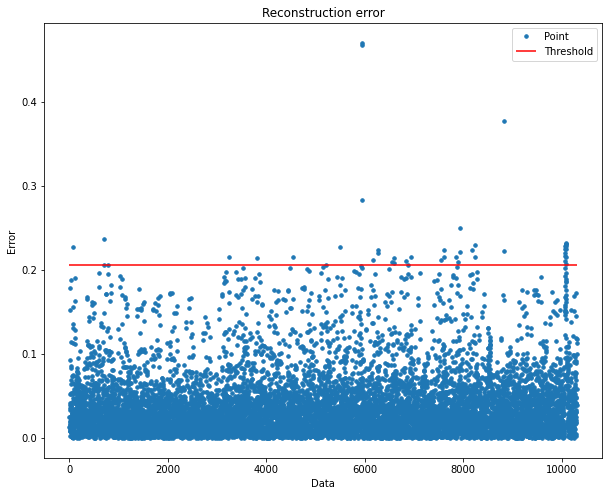

In [289]:


viz.draw_error(error, threshold)



In [290]:


adf = pd.DataFrame({'Datetime': df['Datetime'], 'observation': df['value'],
                    'error': [0 for f in range((time_steps-1))] + error, 'anomaly': [0 for f in range((time_steps-1))]+ y_label})
adf.head(5)



,Datetime,observation,error,anomaly
0,2014-07-01 00:00:00,10844,0.0,0
1,2014-07-01 00:30:00,8127,0.0,0
2,2014-07-01 01:00:00,6210,0.0,0
3,2014-07-01 01:30:00,4656,0.0,0
4,2014-07-01 02:00:00,3820,0.0,0


Text(0.5, 1.0, 'Time Series of value by date time')

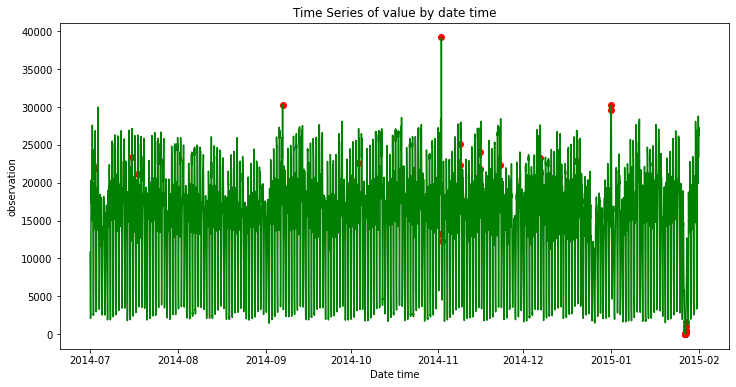

In [291]:


figure, axes = plt.subplots(figsize=(12, 6))
axes.plot(adf['Datetime'], adf['observation'], color='g')
anomaliesDF = adf.query('anomaly == 1')
axes.scatter(anomaliesDF['Datetime'].values, anomaliesDF['observation'], color='r')
plt.xlabel('Date time')
plt.ylabel('observation')
plt.title('Time Series of value by date time')

